In [12]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import matplotlib as mpl

In [2]:
# Loading datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Drop random column
train = train.drop(columns = 'Unnamed: 0')
test = test.drop(columns = 'Unnamed: 0')

In [5]:
# Undersampling 

# Filtering the dataset so that it only has not-readmitted vals
no_readmit = train[train['readmitted'] == 0]
readmit = train[train['readmitted'] == 1]

# Taking a random sample from the no_reamit df 
import random

n = 5041 # To get a 50-50 split, we need a sample of 5041
no_readmit1 = no_readmit.sample(n)

no_readmit.shape # (52173, 48)
readmit.shape # (5041, 48)
no_readmit1.shape # (5041, 48)

# Merging the no_readmit1 and readmit dfs to get a train1 df
merged_df = pd.concat([no_readmit1, readmit])
merged_df.shape

# Randomly shuffling the resulting df
train1 = merged_df.sample(frac=1)

<AxesSubplot:xlabel='readmitted', ylabel='Count'>

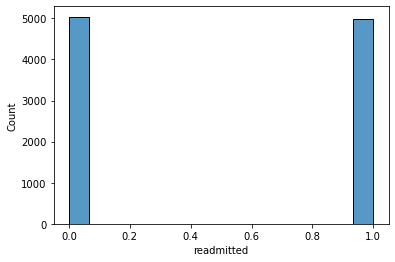

In [87]:
# Distribution is now even; successful undersampling 
sns.histplot(x = "readmitted", data = train1)

In [88]:
train1.corrwith(train1.readmitted).sort_values()

encounter_id               -0.091958
patient_nbr                -0.001665
admission_type_id           0.000449
num_procedures              0.001036
number_outpatient           0.019541
admission_source_id         0.023146
discharge_disposition_id    0.032344
num_of_changes              0.040391
num_lab_procedures          0.048405
number_emergency            0.053311
num_medications             0.061306
number_diagnoses            0.076660
age                         0.078467
time_in_hospital            0.091253
number_inpatient            0.132724
readmitted                  1.000000
dtype: float64

In [89]:
cat_subset = train1.loc[:, ["diag_1", "max_glu_serum", "A1Cresult", "readmitted"]]

In [90]:
cat_dummies = pd.get_dummies(cat_subset)

In [91]:
# None of these vars seem too correlated... 
cat_dummies.corrwith(train1.readmitted).sort_values()

diag_1_respiratory       -0.043546
diag_1_pregnecy          -0.029044
A1Cresult_>8             -0.015050
A1Cresult_>7             -0.014380
max_glu_serum_None       -0.011684
diag_1_digestive         -0.009945
diag_1_other             -0.007192
diag_1_neoplasms         -0.007024
A1Cresult_Norm           -0.002687
diag_1_musculoskeletal   -0.001951
diag_1_diabetes          -0.001150
diag_1_genitourinary      0.002252
max_glu_serum_Norm        0.002839
max_glu_serum_>200        0.004740
max_glu_serum_>300        0.015439
A1Cresult_None            0.019995
diag_1_injury             0.023181
diag_1_circulatory        0.038225
readmitted                1.000000
dtype: float64

In [8]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

In [34]:
train1.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'num_of_changes'],
      dtype='object')

In [93]:
model1 = sm.logit('readmitted ~ time_in_hospital + discharge_disposition_id + diag_1 + number_diagnoses + num_medications + num_procedures + age',
                  train1).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.682677
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10007
Method:                           MLE   Df Model:                           15
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.01508
Time:                        19:55:55   Log-Likelihood:                -6842.5
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 2.435e-36
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.0337      0.125     -8.288      0.000      -1.278      -0.789
diag_1[T.diabetes]           -0.0255      0.083     -0.306      0.760      -0.189       0.138
diag_1[T.digestive]          -0.1647      0.078     -2.100      0.036      -0.318      -0.011
diag_1[T.genitourinary]      -0.1339      0.100     -1.337      0.181      -0.330       0.062
diag_1[T.injury]              0.0020      0.082      0.025      0.980      -0.159       0.163
diag_1[T.musculoskeletal]    -0.1093      0.092     -1.187      0.235      -0.290       0.071
diag_1[T.neoplasms]          -0.2011      0.108     -1.856      0.063      -0.413       0.011
diag_1[T.other]              -0.1781      0.064     -2.796      0.005      -0.303      -0.053
diag_1[T.pregnecy]           -0.4307      0.285     -1.510      0.131      -0.990       0.128
diag_1[T.respiratory]        -0.4015      0.070     -5.738      0.000      -0.539      -0.264
time_in_hospital              0.0462      0.008      5.774      0.000       0.030       0.062
discharge_disposition_id      0.0149      0.005      2.801      0.005       0.004       0.025
number_diagnoses              0.0505      0.011      4.505      0.000       0.029       0.073
num_medications               0.0065      0.003      2.133      0.033       0.001       0.013
num_procedures               -0.0481      0.013     -3.605      0.000      -0.074      -0.022
age                           0.0074      0.001      5.240      0.000       0.005       0.010
=============================================================================================
"""

Classification accuracy = 55.2%
Precision = 11.0%
TPR or Recall = 54.8%
FNR = 45.2%
FPR = 44.8%
ROC-AUC = 57.4%


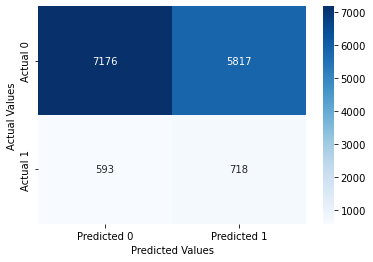

In [37]:
# we want low FNR
confusion_matrix_data(test,test.readmitted, model1)

In [50]:
model2 = sm.logit('readmitted ~ age + number_diagnoses + number_emergency + number_inpatient + time_in_hospital + num_procedures + num_medications', train1).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.676369
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10015
Method:                           MLE   Df Model:                            7
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.02418
Time:                        13:46:34   Log-Likelihood:                -6779.2
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 1.231e-68
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.2337      0.112    -11.027      0.000      -1.453      -1.014
age                  0.0080      0.001      5.939      0.000       0.005       0.011
number_diagnoses     0.0480      0.011      4.274      0.000       0.026       0.070
number_emergency     0.1049      0.041      2.554      0.011       0.024       0.185
number_inpatient     0.3849      0.033     11.496      0.000       0.319       0.450
time_in_hospital     0.0299      0.008      3.846      0.000       0.015       0.045
num_procedures      -0.0198      0.013     -1.551      0.121      -0.045       0.005
num_medications      0.0073      0.003      2.432      0.015       0.001       0.013
====================================================================================
"""

Classification accuracy = 63.0%
Precision = 12.2%
TPR or Recall = 49.2%
FNR = 50.8%
FPR = 35.6%
ROC-AUC = 59.9%


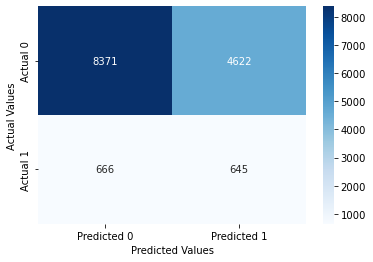

In [51]:
confusion_matrix_data(test,test.readmitted, model2)

In [52]:
model3 = sm.logit('readmitted ~ age + number_diagnoses + number_inpatient + time_in_hospital + num_medications', train1).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.676847
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10017
Method:                           MLE   Df Model:                            5
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.02349
Time:                        13:47:28   Log-Likelihood:                -6784.0
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 2.096e-68
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.2257      0.112    -10.986      0.000      -1.444      -1.007
age                  0.0079      0.001      5.869      0.000       0.005       0.011
number_diagnoses     0.0498      0.011      4.444      0.000       0.028       0.072
number_inpatient     0.4000      0.033     12.063      0.000       0.335       0.465
time_in_hospital     0.0294      0.008      3.778      0.000       0.014       0.045
num_medications      0.0055      0.003      1.955      0.051   -1.46e-05       0.011
====================================================================================
"""

Classification accuracy = 63.0%
Precision = 12.0%
TPR or Recall = 48.1%
FNR = 51.9%
FPR = 35.5%
ROC-AUC = 59.7%


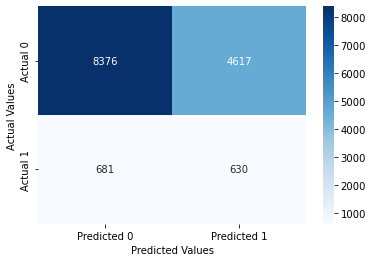

In [53]:
confusion_matrix_data(test,test.readmitted, model3)

In [77]:
model4 = sm.logit('readmitted ~ age + number_inpatient + time_in_hospital*num_lab_procedures + number_diagnoses', train1).fit()
model4.summary()

Optimization terminated successfully.
         Current function value: 0.676824
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10016
Method:                           MLE   Df Model:                            6
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.02352
Time:                        13:58:19   Log-Likelihood:                -6783.8
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 1.421e-67
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -1.3226      0.131    -10.070      0.000      -1.580      -1.065
age                                     0.0077      0.001      5.752      0.000       0.005       0.010
number_inpatient                        0.3956      0.033     11.911      0.000       0.331       0.461
time_in_hospital                        0.0555      0.018      3.088      0.002       0.020       0.091
num_lab_procedures                      0.0038      0.002      2.020      0.043       0.000       0.007
time_in_hospital:num_lab_procedures    -0.0005      0.000     -1.386      0.166      -0.001       0.000
number_diagnoses                        0.0520      0.011      4.689      0.000       0.030       0.074
=======================================================================================================
"""

Classification accuracy = 62.4%
Precision = 12.0%
TPR or Recall = 48.9%
FNR = 51.1%
FPR = 36.2%
ROC-AUC = 59.9%


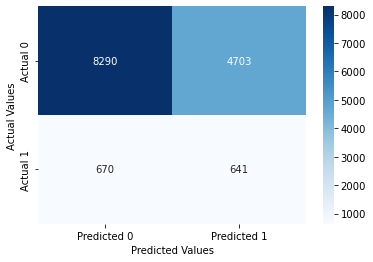

In [78]:
confusion_matrix_data(test,test.readmitted, model4)

In [94]:
model5 = sm.logit('readmitted ~ age + number_inpatient + time_in_hospital + number_diagnoses + num_of_changes', train1).fit()
model5.summary()

Optimization terminated successfully.
         Current function value: 0.676086
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10017
Method:                           MLE   Df Model:                            5
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.02459
Time:                        20:00:23   Log-Likelihood:                -6776.4
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 1.094e-71
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.2120      0.111    -10.963      0.000      -1.429      -0.995
age                  0.0088      0.001      6.493      0.000       0.006       0.011
number_inpatient     0.3972      0.033     11.999      0.000       0.332       0.462
time_in_hospital     0.0422      0.007      5.940      0.000       0.028       0.056
number_diagnoses     0.0400      0.011      3.628      0.000       0.018       0.062
num_of_changes       0.1258      0.043      2.937      0.003       0.042       0.210
====================================================================================
"""

Classification accuracy = 63.2%
Precision = 12.1%
TPR or Recall = 48.0%
FNR = 52.0%
FPR = 35.2%
ROC-AUC = 59.9%


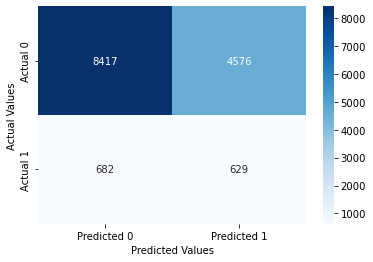

In [83]:
confusion_matrix_data(test,test.readmitted, model5)

In [95]:
model6 = sm.logit('readmitted ~ age + number_inpatient + time_in_hospital + number_diagnoses + num_of_changes + discharge_disposition_id', train1).fit()
model6.summary()

Optimization terminated successfully.
         Current function value: 0.675457
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10016
Method:                           MLE   Df Model:                            6
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.02550
Time:                        20:01:57   Log-Likelihood:                -6770.1
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 1.869e-73
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.2557      0.111    -11.277      0.000      -1.474      -1.037
age                          0.0087      0.001      6.400      0.000       0.006       0.011
number_inpatient             0.4018      0.033     12.111      0.000       0.337       0.467
time_in_hospital             0.0405      0.007      5.684      0.000       0.027       0.054
number_diagnoses             0.0420      0.011      3.800      0.000       0.020       0.064
num_of_changes               0.1314      0.043      3.066      0.002       0.047       0.215
discharge_disposition_id     0.0189      0.005      3.539      0.000       0.008       0.029
============================================================================================
"""

Classification accuracy = 63.6%
Precision = 12.1%
TPR or Recall = 47.4%
FNR = 52.6%
FPR = 34.7%
ROC-AUC = 59.8%


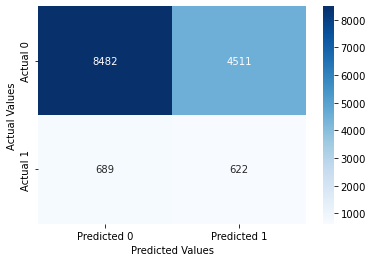

In [96]:
confusion_matrix_data(test,test.readmitted, model6)

In [101]:
model7 = sm.logit('readmitted ~ age + time_in_hospital + discharge_disposition_id + number_inpatient + num_of_changes', train1).fit()
model7.summary()

Optimization terminated successfully.
         Current function value: 0.676179
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10017
Method:                           MLE   Df Model:                            5
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.02446
Time:                        20:04:12   Log-Likelihood:                -6777.3
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 2.749e-71
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.0347      0.094    -10.956      0.000      -1.220      -0.850
age                          0.0096      0.001      7.236      0.000       0.007       0.012
time_in_hospital             0.0458      0.007      6.559      0.000       0.032       0.060
discharge_disposition_id     0.0178      0.005      3.355      0.001       0.007       0.028
number_inpatient             0.4086      0.033     12.301      0.000       0.344       0.474
num_of_changes               0.1396      0.043      3.261      0.001       0.056       0.223
============================================================================================
"""

Classification accuracy = 64.5%
Precision = 12.2%
TPR or Recall = 46.6%
FNR = 53.4%
FPR = 33.7%
ROC-AUC = 59.9%


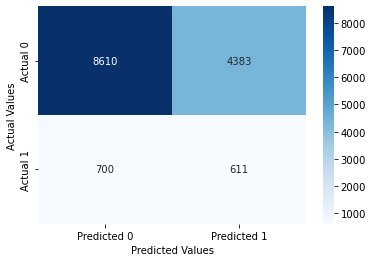

In [102]:
confusion_matrix_data(test,test.readmitted, model7)

In [103]:
# Interaction between disposition ID and num of changes
model8 = sm.logit('readmitted ~ age + time_in_hospital + number_inpatient + discharge_disposition_id*num_of_changes', train1).fit()
model8.summary()

Optimization terminated successfully.
         Current function value: 0.676174
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10016
Method:                           MLE   Df Model:                            6
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.02446
Time:                        20:05:21   Log-Likelihood:                -6777.3
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 2.271e-70
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -1.0330      0.095    -10.919      0.000      -1.218      -0.848
age                                         0.0096      0.001      7.236      0.000       0.007       0.012
time_in_hospital                            0.0459      0.007      6.563      0.000       0.032       0.060
number_inpatient                            0.4086      0.033     12.300      0.000       0.343       0.474
discharge_disposition_id                    0.0170      0.006      2.853      0.004       0.005       0.029
num_of_changes                              0.1315      0.050      2.644      0.008       0.034       0.229
discharge_disposition_id:num_of_changes     0.0040      0.013      0.319      0.749      -0.021       0.029
===========================================================================================================
"""

Classification accuracy = 64.5%
Precision = 12.3%
TPR or Recall = 46.6%
FNR = 53.4%
FPR = 33.7%
ROC-AUC = 59.9%


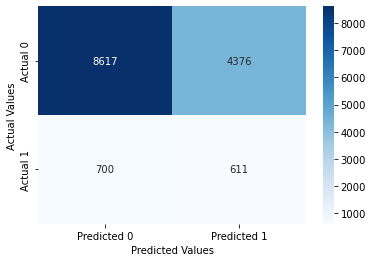

In [104]:
confusion_matrix_data(test,test.readmitted, model8)

In [109]:
# Interaction btw num changes and age ... 
model9 = sm.logit('readmitted ~ discharge_disposition_id + time_in_hospital + number_inpatient + num_of_changes*age', train1).fit()
model9.summary()

Optimization terminated successfully.
         Current function value: 0.676105
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10016
Method:                           MLE   Df Model:                            6
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.02456
Time:                        20:07:18   Log-Likelihood:                -6776.6
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 1.153e-70
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.1011      0.109    -10.074      0.000      -1.315      -0.887
discharge_disposition_id     0.0178      0.005      3.348      0.001       0.007       0.028
time_in_hospital             0.0460      0.007      6.586      0.000       0.032       0.060
number_inpatient             0.4090      0.033     12.313      0.000       0.344       0.474
num_of_changes               0.3521      0.180      1.954      0.051      -0.001       0.705
age                          0.0106      0.002      6.815      0.000       0.008       0.014
num_of_changes:age          -0.0032      0.003     -1.214      0.225      -0.008       0.002
============================================================================================
"""

Classification accuracy = 63.7%
Precision = 12.3%
TPR or Recall = 48.5%
FNR = 51.5%
FPR = 34.7%
ROC-AUC = 59.9%


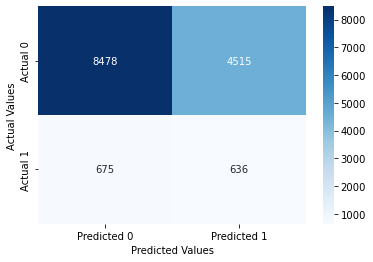

In [110]:
confusion_matrix_data(test,test.readmitted, model9)

In [6]:
# using visualizaitons: 
# Interaction btw changes and time 
model10 = sm.logit('readmitted ~ num_of_changes*time_in_hospital + number_inpatient + age', train1).fit()
model10.summary()

Optimization terminated successfully.
         Current function value: 0.677928
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10017
Method:                           MLE   Df Model:                            5
Date:                Sun, 26 Feb 2023   Pseudo R-squ.:                 0.02193
Time:                        10:12:37   Log-Likelihood:                -6794.9
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 9.641e-64
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.9796      0.096    -10.191      0.000      -1.168      -0.791
num_of_changes                      0.3339      0.082      4.069      0.000       0.173       0.495
time_in_hospital                    0.0602      0.008      7.287      0.000       0.044       0.076
num_of_changes:time_in_hospital    -0.0415      0.013     -3.150      0.002      -0.067      -0.016
number_inpatient                    0.3754      0.032     11.680      0.000       0.312       0.438
age                                 0.0086      0.001      6.503      0.000       0.006       0.011
===================================================================================================
"""

Classification accuracy = 57.2%
Precision = 58.4%
TPR or Recall = 48.3%
FNR = 51.7%
FPR = 34.0%
ROC-AUC = 59.9%


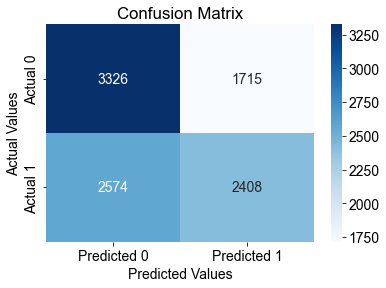

In [15]:
# Printing the confusion matrix of the model
confusion_matrix_data(train1,train1.readmitted,model10)
plt.title('Confusion Matrix')
mpl.rc('font', family='Arial', size=14)
plt.savefig("initial_confusion_matrix_train.png", dpi=300)

Classification accuracy = 63.6%
Precision = 12.4%
TPR or Recall = 48.9%
FNR = 51.1%
FPR = 34.9%
ROC-AUC = 60.0%


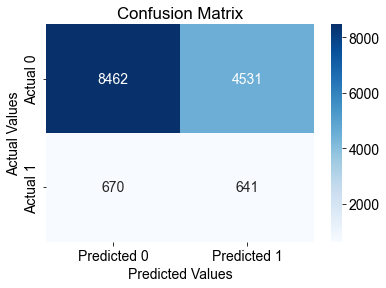

In [16]:
# Printing the confusion matrix of the model
confusion_matrix_data(test,test.readmitted,model10)
plt.title('Confusion Matrix')
mpl.rc('font', family='Arial', size=14)
plt.savefig("initial_confusion_matrix_test.png", dpi=300)

In [118]:
# using visualizations: 
# Interaction btw age and time 
model11 = sm.logit('readmitted ~ num_of_changes + age*time_in_hospital + number_inpatient', train1).fit()
model11.summary()

Optimization terminated successfully.
         Current function value: 0.676657
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10017
Method:                           MLE   Df Model:                            5
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.02377
Time:                        21:16:57   Log-Likelihood:                -6782.1
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 3.172e-69
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.1739      0.160     -7.345      0.000      -1.487      -0.861
num_of_changes           0.1340      0.043      3.136      0.002       0.050       0.218
age                      0.0122      0.002      5.201      0.000       0.008       0.017
time_in_hospital         0.0887      0.032      2.761      0.006       0.026       0.152
age:time_in_hospital    -0.0006      0.000     -1.323      0.186      -0.002       0.000
number_inpatient         0.4045      0.033     12.205      0.000       0.340       0.470
========================================================================================
"""

Classification accuracy = 62.9%
Precision = 12.3%
TPR or Recall = 49.4%
FNR = 50.6%
FPR = 35.7%
ROC-AUC = 60.2%


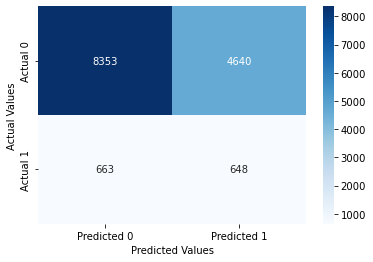

In [119]:
confusion_matrix_data(test,test.readmitted, model11)

In [120]:
# both interactions: 
model12 = sm.logit('readmitted ~ num_of_changes*time_in_hospital + age*time_in_hospital + number_inpatient', train1).fit()
model12.summary()

Optimization terminated successfully.
         Current function value: 0.676155
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                10023
Model:                          Logit   Df Residuals:                    10016
Method:                           MLE   Df Model:                            6
Date:                Sun, 19 Feb 2023   Pseudo R-squ.:                 0.02449
Time:                        21:18:14   Log-Likelihood:                -6777.1
converged:                       True   LL-Null:                       -6947.2
Covariance Type:            nonrobust   LLR p-value:                 1.879e-70
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.2659      0.163     -7.784      0.000      -1.585      -0.947
num_of_changes                      0.3545      0.082      4.346      0.000       0.195       0.514
time_in_hospital                    0.1090      0.033      3.329      0.001       0.045       0.173
num_of_changes:time_in_hospital    -0.0424      0.013     -3.178      0.001      -0.069      -0.016
age                                 0.0127      0.002      5.384      0.000       0.008       0.017
age:time_in_hospital               -0.0007      0.000     -1.517      0.129      -0.002       0.000
number_inpatient                    0.4032      0.033     12.166      0.000       0.338       0.468
===================================================================================================
"""

Classification accuracy = 61.7%
Precision = 12.2%
TPR or Recall = 51.0%
FNR = 49.0%
FPR = 37.2%
ROC-AUC = 59.9%


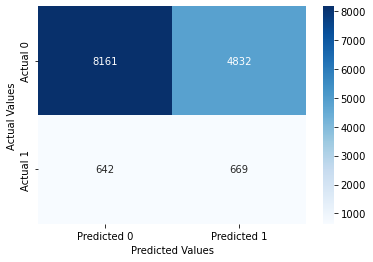

In [121]:
confusion_matrix_data(test,test.readmitted, model12)

# visualizing distributions

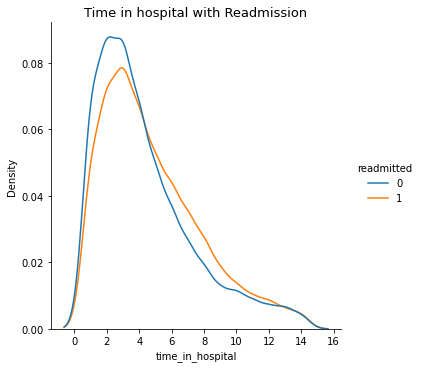

In [54]:
# time in hospital
sns.displot(train1, x="time_in_hospital", hue= 'readmitted', kind="kde")
plt.title('Time in hospital with Readmission', size = 13)
plt.show()

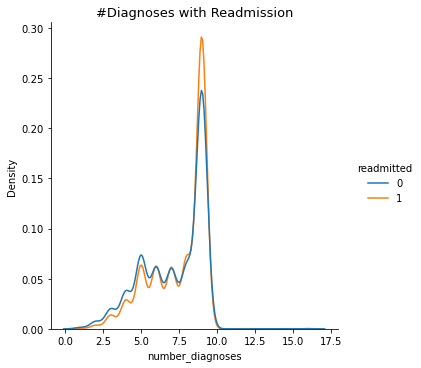

In [55]:
# number diagnoses
sns.displot(train1, x="number_diagnoses", hue= 'readmitted', kind="kde")
plt.title('#Diagnoses with Readmission', size = 13)
plt.show()

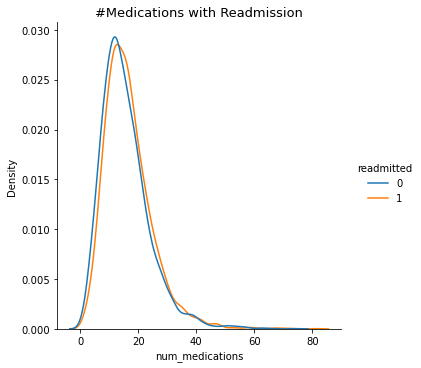

In [56]:
# num medications
sns.displot(train1, x="num_medications", hue= 'readmitted', kind="kde")
plt.title('#Medications with Readmission', size = 13)
plt.show()

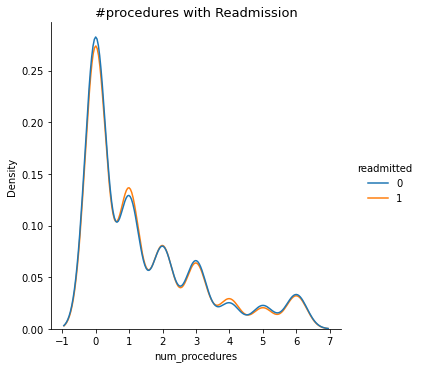

In [57]:
# num procedures
sns.displot(train1, x="num_procedures", hue= 'readmitted', kind="kde")
plt.title('#Procedures with Readmission', size = 13)
plt.show()

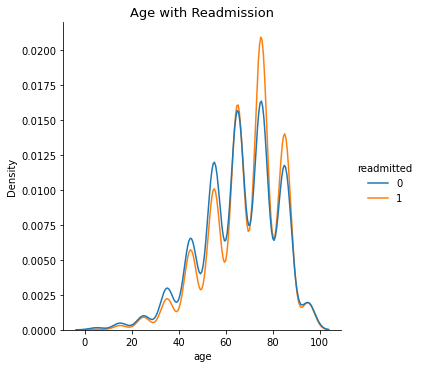

In [58]:
# age
sns.displot(train1, x="age", hue= 'readmitted', kind="kde")
plt.title('Age with Readmission', size = 13)
plt.show()

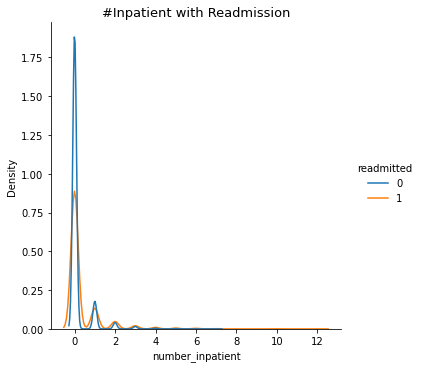

In [59]:
# num inpatient
sns.displot(train1, x="number_inpatient", hue= 'readmitted', kind="kde")
plt.title('#Inpatient with Readmission', size = 13)
plt.show()

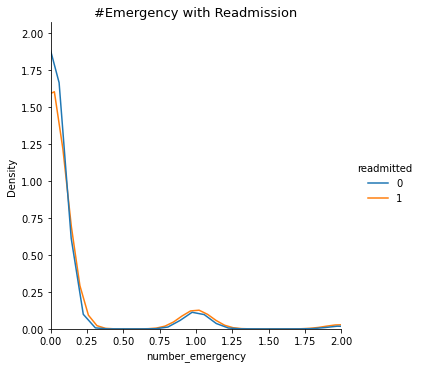

In [62]:
# num emergency 
sns.displot(train1, x="number_emergency", hue= 'readmitted', kind="kde")
plt.title('#Emergency with Readmission', size = 13)
plt.xlim(0, 2)
plt.show()

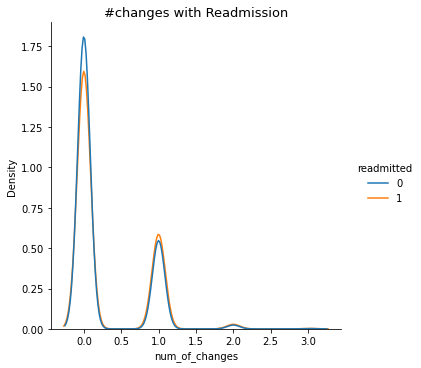

In [80]:
# num of changes 
sns.displot(train1, x="num_of_changes", hue= 'readmitted', kind="kde")
plt.title('#changes with Readmission', size = 13)
plt.show()